In [94]:
import openai
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

openai.api_key = os.getenv("OPENAI_API_KEY")

In [30]:
df = pd.read_csv('fine_food_reviews_1k.csv', index_col=0)
df = df.dropna()
df["combined"] = ("Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip())

In [ ]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

# df['ada_embedding'] = df.combined.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
# df.to_csv('fine_food_reviews_with_embeddings_1k.csv', index=False)

In [68]:
df = pd.read_csv('fine_food_reviews_with_embeddings_1k.csv')
df.embedding = df.embedding.apply(eval).apply(np.array)
df

,Unnamed: 0,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
0,0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.007018072064965963, -0.02731654793024063, 0..."
1,297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.003140551969408989, -0.009995664469897747,..."
2,296,B008JKTTUA,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[-0.01757248118519783, -8.266511576948687e-05,..."
3,295,B000LKTTTW,A14MQ40CCU8B13,5,Best tomato soup,I have a hard time finding packaged food of an...,Title: Best tomato soup; Content: I have a har...,111,"[-0.0013932279543951154, -0.011112828738987446..."
4,294,B001D09KAM,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[-0.01757248118519783, -8.266511576948687e-05,..."
...,...,...,...,...,...,...,...,...,...
995,623,B0000CFXYA,A3GS4GWPIBV0NT,1,Strange inflammation response,Truthfully wasn't crazy about the taste of the...,Title: Strange inflammation response; Content:...,110,"[0.00011091353371739388, -0.00466986745595932,..."
996,624,B0001BH5YM,A1BZ3HMAKK0NC,5,My favorite and only MUSTARD,You've just got to experience this mustard... ...,Title: My favorite and only MUSTARD; Content:...,80,"[-0.020869314670562744, -0.013138455338776112,..."
997,625,B0009ET7TC,A2FSDQY5AI6TNX,5,My furbabies LOVE these!,Shake the container and they come running. Eve...,Title: My furbabies LOVE these!; Content: Shak...,47,"[-0.009749102406203747, -0.0068712360225617886..."
998,619,B007PA32L2,A15FF2P7RPKH6G,5,got this for the daughter,all i have heard since she got a kuerig is why...,Title: got this for the daughter; Content: all...,50,"[-0.00521062919870019, 0.0009606690146028996, ..."


In [81]:
mean_of_embedding = [np.median(x) for x in df.embedding]

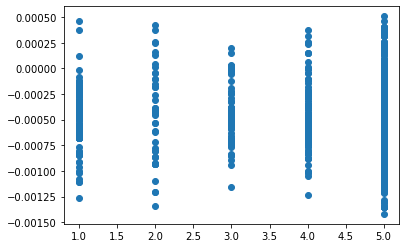

In [82]:
plt.scatter(df.Score, mean_of_embedding)

In [143]:
tsne = TSNE(n_components=2, perplexity=15, random_state=2, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(np.stack(df.embedding))

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

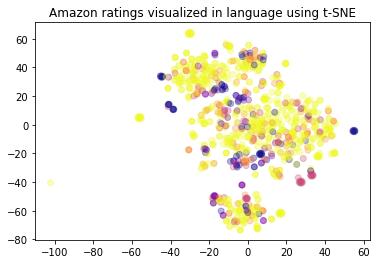

In [153]:
plt.scatter(vis_dims[:,0], vis_dims[:,1], c = df.Score, cmap='plasma', alpha=0.3)
plt.title("Amazon ratings visualized in language using t-SNE")

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values),
    df.Score,
    test_size = 0.2,
    random_state=42
)

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
preds = rfr.predict(X_test)

In [156]:
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"ada-002 embedding performance on 1k Amazon reviews: mse={mse:.2f}, mae={mae:.2f}")


ada-002 embedding performance on 1k Amazon reviews: mse=0.61, mae=0.53


In [157]:
bmse = mean_squared_error(y_test, np.repeat(y_test.mean(), len(y_test)))
bmae = mean_absolute_error(y_test, np.repeat(y_test.mean(), len(y_test)))
print(f"Dummy mean prediction performance on Amazon reviews: mse={bmse:.2f}, mae={bmae:.2f}")


Dummy mean prediction performance on Amazon reviews: mse=1.73, mae=1.03


#### We get an average error of 0.61 per score prediction, compared to 1.73 when just using the average score as a prediction.
